# Trying to predict Aurora (K-index)

# Step 1: Fetch and Aggregate Weather Data
## Update the weather data fetching and processing to ensure the date column contains only date information:

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import to_date, lpad, concat_ws

# Создание Spark сессии
spark = SparkSession.builder \
    .appName("MongoDBIntegration") \
    .config("spark.mongodb.read.connection.uri", "mongodb://mongodb:27017") \
    .config("spark.mongodb.write.connection.uri", "mongodb://mongodb:27017") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.mongodb.read.database", "wether_db") \
    .getOrCreate()

aurora_df = spark.read \
    .format("mongo") \
    .option("uri", "mongodb://mongodb:27017/wether_db.aurora_weather") \
    .load()

solar_activity_df = spark.read \
    .format("mongo") \
    .option("uri", "mongodb://mongodb:27017/wether_db.solar_activity") \
    .load()


# Pad Month and Day with leading zeros to ensure two digits
spark_df = solar_activity_df.withColumn("Month", lpad(col("Month"), 2, '0'))
spark_df = spark_df.withColumn("Day", lpad(col("Day"), 2, '0'))

# Combine Year, Month, and Day into a single Date column
spark_df = spark_df.withColumn("Date", concat_ws("-", col("Year"), col("Month"), col("Day")))
spark_df = spark_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Select relevant columns to display
selected_columns = [
    "Date","BSR", "DB", "Kp_00_03", "Kp_03_06", "Kp_06_09", "Kp_09_12",
    "Kp_12_15", "Kp_15_18", "Kp_18_21", "Kp_21_24",
    "Ap", "SN", "F10_7obs", "F10_7adj"
]

# Filter and display the data
solar_activity_df = spark_df.select(selected_columns)

# Показ первых 5 строк
print("Aurora DataFrame:")
aurora_df.show(5)

# Показ первых 5 строк
print("solar_activity_df DataFrame:")
solar_activity_df.show(5)

Aurora DataFrame:
+--------------------+-------------+-----------------+------------------------+----------------+------------------------+-------------+-------------------+------------------+------------------+------------------+
|                 _id|         date|diffuse_radiation|direct_normal_irradiance|direct_radiation|global_tilted_irradiance|           id|shortwave_radiation|temperature_2m_max|temperature_2m_min|wind_speed_10m_max|
+--------------------+-------------+-----------------+------------------------+----------------+------------------------+-------------+-------------------+------------------+------------------+------------------+
|{667c1b7c766ffe44...|1577836800000|           13.125|           102.867729187|   19.3333339691|           32.4583320618|1577836800000|      32.4583320618|      4.1184997559|     -3.2315001488|     10.7398328781|
|{667c1b7c766ffe44...|1577923200000|    11.0416669846|          172.4806976318|   33.4583320618|           44.4999961853|157792320

# Step 3: Merge DataFrames
## Merge the weather and aurora data on the date column:

In [11]:
# Join weather data with aurora data
merged_df = aurora_df.join(aurora_df, aurora_df.date == solar_activity_df.Date, "inner").drop(aurora_df.Date)

# Show the merged DataFrame
# merged_df.select('date','temperature_2m_max', 'Kp_03_06').show()
merged_df.show()

AnalysisException: Column date#974L are ambiguous. It's probably because you joined several Datasets together, and some of these Datasets are the same. This column points to one of the Datasets but Spark is unable to figure out which one. Please alias the Datasets with different names via `Dataset.as` before joining them, and specify the column using qualified name, e.g. `df.as("a").join(df.as("b"), $"a.id" > $"b.id")`. You can also set spark.sql.analyzer.failAmbiguousSelfJoin to false to disable this check.

# Step 4: Feature Engineering and Model Training
## Create additional features and prepare the data for model training:

In [83]:
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Extract year, month, and day from the date column
merged_df = merged_df.withColumn("year", year(col("date")))
merged_df = merged_df.withColumn("month", month(col("date")))
merged_df = merged_df.withColumn("day", dayofmonth(col("date")))

# Prepare features and labels
assembler = VectorAssembler(
    inputCols=[
        "temperature_2m_max", 
        "temperature_2m_min", 
        "wind_speed_10m_max",
        "shortwave_radiation",
        "direct_radiation",
        "diffuse_radiation",
        "direct_normal_irradiance",
        "global_tilted_irradiance",
        "BSR",
        "Ap",
        "SN",
        "F10_7obs",
        "F10_7adj",
        "year",
        "month",
        "day"
    ],
    outputCol="features"
)

# Prepare the data
data = assembler.transform(merged_df)
data = data.select("date", "features", col("Kp_00_03").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the models
rf_model = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=75, maxDepth=7)
gbt_model = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=10)

# Train the models
rf_model = rf_model.fit(train_data)
gbt_model = gbt_model.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the models
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

gbt_rmse = evaluator.evaluate(gbt_predictions)
gbt_r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})

print(f"Random Forest - Root Mean Squared Error (RMSE): {rf_rmse}")
print(f"Random Forest - R2: {rf_r2}")

print(f"Gradient Boosting - Root Mean Squared Error (RMSE): {gbt_rmse}")
print(f"Gradient Boosting - R2: {gbt_r2}")

# Show some predictions
rf_predictions.select("date", "label", "prediction").show()
gbt_predictions.select("date", "label", "prediction").show()

Random Forest - Root Mean Squared Error (RMSE): 0.9598636987613385
Random Forest - R2: 0.4641538587553916
Gradient Boosting - Root Mean Squared Error (RMSE): 1.0202343490149846
Gradient Boosting - R2: 0.3946300554505281
+----------+-----+------------------+
|      date|label|        prediction|
+----------+-----+------------------+
|2020-01-03|0.667| 1.607419028078424|
|2020-01-07|  1.0| 1.236805733453967|
|2020-01-09|2.667|  2.10932279787478|
|2020-01-14|0.333| 0.774046768545746|
|2020-01-20|  0.0|0.7596611537282121|
|2020-01-24|  1.0|0.7792891844313735|
|2020-01-30|  2.0| 2.293498187117722|
|2020-02-05|1.667|  1.21788749885397|
|2020-02-15|  1.0|1.1709903107724573|
|2020-02-16|2.333|0.8859484815372808|
|2020-02-17|1.333| 1.776733559216722|
|2020-02-19|2.333| 2.176887262382716|
|2020-02-21|3.667|2.1275657932563665|
|2020-02-25|1.333|0.9542747485600368|
|2020-03-03|  2.0|1.4500502034546177|
|2020-03-10|  2.0|0.9833005365497549|
|2020-03-18|0.333|1.5914572604647563|
|2020-04-10|  0.0|1.

# Step 5: Visualization
## Visualize the actual vs predicted Kp index values for both models.

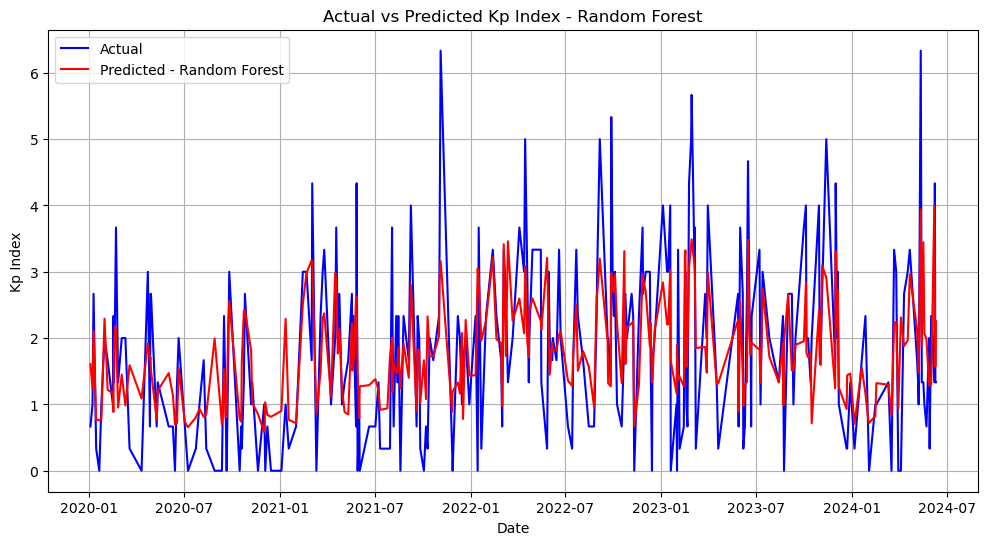

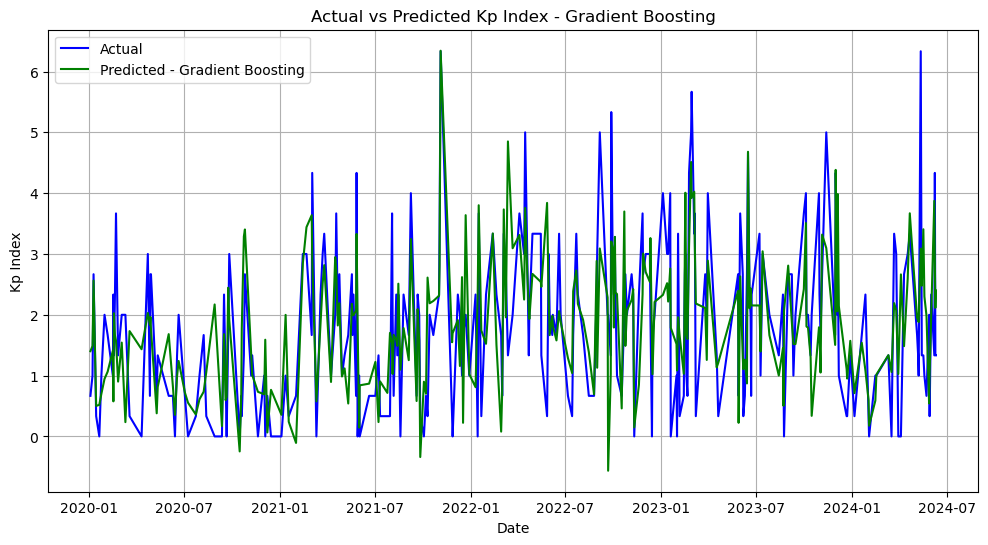

In [85]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
rf_predictions_pd = rf_predictions.select("date", "label", "prediction").toPandas()
gbt_predictions_pd = gbt_predictions.select("date", "label", "prediction").toPandas()

# Plot actual vs predicted Kp index values for Random Forest
plt.figure(figsize=(12, 6))
plt.plot(rf_predictions_pd['date'], rf_predictions_pd['label'], label='Actual', color='blue')
plt.plot(rf_predictions_pd['date'], rf_predictions_pd['prediction'], label='Predicted - Random Forest', color='red')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.title('Actual vs Predicted Kp Index - Random Forest')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted Kp index values for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.plot(gbt_predictions_pd['date'], gbt_predictions_pd['label'], label='Actual', color='blue')
plt.plot(gbt_predictions_pd['date'], gbt_predictions_pd['prediction'], label='Predicted - Gradient Boosting', color='green')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.title('Actual vs Predicted Kp Index - Gradient Boosting')
plt.legend()
plt.grid()
plt.show()
